In [1]:
import sys
sys.path.append('../scripts/')
from read_utils import read_file, create_folder, temp_record_query, temp_record_sdf

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = (
    # Create a spark session (which will run spark jobs)
    SparkSession.builder.appName("Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config('spark.executor.memory','10g')
    .config('spark.driver.memory','12g')
    .config('spark.driver.maxResultsSize', '10GiB')
    # .config("spark.network.timeout", "3600s")
    # .master("local[6]")
    .getOrCreate()
    )

22/10/08 16:27:32 WARN Utils: Your hostname, Runyus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.3.12 instead (on interface en0)
22/10/08 16:27:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/08 16:27:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/08 16:27:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


- dataset

In [4]:
trans_sdf = read_file(spark, 'changed_data', '../data/curated/')

|> Loading File...


|> Loading Finished!
22/10/08 16:28:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
-RECORD 0---------------------------------------------------------------------------------------------
 POA_CODE21        | 2040                                                                             
 user_id           | 11893                                                                            
 merchant_abn      | 90578415511                                                                      
 dollar_value      | 131.14483377730215                                                               
 order_id          | 1db43d10-b5f2-4afc-b94a-948cfa1879f1                                             
 merchant_name     | A Scelerisque Foundation                                                         
 tags              | furniture, home furnishings and equipment shops, and manu

In [5]:
merchant_fraud_sdf = read_file(spark,'merchant_fraud_probability.csv', '../data/tables/', 'csv')

|> Loading File...
|> Loading Finished!
-RECORD 0-------------------------------
 merchant_abn      | 19492220327        
 order_datetime    | 2021-11-28         
 fraud_probability | 44.403658647495355 
only showing top 1 row



In [6]:
merchant_fraud_sdf.show(5)

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
| 31334588839|    2021-10-02| 42.75530083865367|
| 19492220327|    2021-12-22|38.867790051131095|
| 82999039227|    2021-12-19|  94.1347004808891|
| 90918180829|    2021-09-02| 43.32551731714902|
+------------+--------------+------------------+
only showing top 5 rows



In [7]:
trans_sdf.show(5)

+----------+-------+------------+------------------+--------------------+--------------------+--------------------+---------+----+--------+-----------+----------------+-------------------+-----+------+-----------------+---------------+----------+------------+-----------------+------------------+------------------+-----------+---------+--------+---------------+--------------+
|POA_CODE21|user_id|merchant_abn|      dollar_value|            order_id|       merchant_name|                tags|take_rate|type|postcode|consumer_id|            name|            address|state|gender|       population|New cases / day|     month|total_retail|__index_level_0__|          latitude|         longitude|genderIndex|typeIndex|tagIndex|        tag_vec|order_datetime|
+----------+-------+------------+------------------+--------------------+--------------------+--------------------+---------+----+--------+-----------+----------------+-------------------+-----+------+-----------------+---------------+---------

In [8]:
sdf = trans_sdf.select('user_id', 'merchant_abn', 'order_datetime', 'dollar_value', 'take_rate', 'consumer_id', 'POA_CODE21', 'genderIndex', 'typeIndex', 'tagIndex', 'tag_vec')

In [9]:
sdf.show(5)

+-------+------------+--------------+------------------+---------+-----------+----------+-----------+---------+--------+---------------+
|user_id|merchant_abn|order_datetime|      dollar_value|take_rate|consumer_id|POA_CODE21|genderIndex|typeIndex|tagIndex|        tag_vec|
+-------+------------+--------------+------------------+---------+-----------+----------+-----------+---------+--------+---------------+
|  11893| 90578415511|    2021-11-26|131.14483377730215|     5.95|     245147|      2040|        1.0|      0.0|    10.0|(24,[10],[1.0])|
|   9174| 64203420245|    2021-11-26|42.647866295122945|     2.86|    1392834|      2000|        0.0|      2.0|     0.0| (24,[0],[1.0])|
|  12642| 21439773999|    2021-11-26| 40.05069328365354|      6.1|     331077|      5556|        1.0|      0.0|     4.0| (24,[4],[1.0])|
|   9174| 64203420245|    2021-11-26|42.647866295122945|     2.86|    1392834|      2000|        0.0|      2.0|     0.0| (24,[0],[1.0])|
|  12642| 89726005175|    2021-11-26| 23.

In [10]:
import pyspark.sql.functions as F
from pyspark.sql.functions import datediff

In [11]:
sdf_merchant = sdf.groupby('merchant_abn').agg(
    F.count("*").alias("total_sales"), 
    F.avg("dollar_value").alias("sales_average"),
    F.datediff(F.max('order_datetime'),F.min('order_datetime')).alias('sales_duration')
)

In [12]:
sdf_merchant.show(5)

+------------+-----------+------------------+--------------+
|merchant_abn|total_sales|     sales_average|sales_duration|
+------------+-----------+------------------+--------------+
| 38700038932|      23324|1335.2078229425183|           183|
| 83412691377|      42772|  34.9804574021159|           183|
| 35344855546|       3043|  74.7315157226243|           183|
| 41956465747|        659|235.87829958362224|           181|
| 73256306726|      16675| 238.9866066876395|           183|
+------------+-----------+------------------+--------------+
only showing top 5 rows



In [13]:
sdf_merchant = (sdf_merchant
    .withColumn('sales_frequency', ((sdf_merchant.total_sales / sdf_merchant.sales_duration)))
    .withColumn('single_sale_duration', ((sdf_merchant.sales_duration / sdf_merchant.total_sales))))

In [14]:
sdf_merchant.show(5)

+------------+-----------+------------------+--------------+------------------+--------------------+
|merchant_abn|total_sales|     sales_average|sales_duration|   sales_frequency|single_sale_duration|
+------------+-----------+------------------+--------------+------------------+--------------------+
| 38700038932|      23324|1335.2078229425183|           183| 127.4535519125683|0.007845995541073573|
| 83412691377|      42772|  34.9804574021159|           183|233.72677595628414|0.004278499953240438|
| 35344855546|       3043|  74.7315157226243|           183|16.628415300546447| 0.06013802168912258|
| 41956465747|        659|235.87829958362224|           181|3.6408839779005526|  0.2746585735963581|
| 73256306726|      16675| 238.9866066876395|           183| 91.12021857923497|0.010974512743628186|
+------------+-----------+------------------+--------------+------------------+--------------------+
only showing top 5 rows



In [15]:
sdf_daily = sdf.groupby('merchant_abn', 'order_datetime', 'take_rate', 'typeIndex', 'tagIndex', 'tag_vec').agg(
    F.count("*").alias("daily_sales"), 
    F.avg("dollar_value").alias("daily_average"),
    F.min("dollar_value").alias("trans_min"),
    F.max("dollar_value").alias("trans_max"),
    )

In [16]:
sdf_daily

merchant_abn,order_datetime,take_rate,typeIndex,tagIndex,tag_vec,daily_sales,daily_average,trans_min,trans_max
80166805919,2021-11-26,1.56,2.0,12.0,"(24,[12],[1.0])",32,156.16499955185907,23.979396106415884,623.094259904411
34437937876,2021-11-26,6.27,0.0,3.0,"(24,[3],[1.0])",3,20.74124102329653,3.192787071358202,40.474833082261874
37023533442,2021-11-26,2.19,2.0,0.0,"(24,[0],[1.0])",176,61.342470858546534,14.186750040308574,149.4257681136218
73440621827,2021-11-26,4.59,1.0,7.0,"(24,[7],[1.0])",7,186.69440919838706,65.12876764910285,480.09799903234966
83575543026,2021-11-26,1.42,2.0,20.0,"(24,[20],[1.0])",21,200.85778448425043,26.295523078031113,529.3704696109866
54273147353,2021-11-26,2.8,2.0,9.0,"(24,[9],[1.0])",2,794.6621500377564,132.50451361223745,1456.8197864632755
73500416211,2021-11-26,4.61,1.0,7.0,"(24,[7],[1.0])",4,137.2679904261545,72.92361780475363,193.43509731899758
92437353435,2021-11-26,4.77,1.0,9.0,"(24,[9],[1.0])",4,373.41874351926367,328.1597135397395,418.3942550932043
21162389643,2021-11-26,6.3,0.0,17.0,"(24,[17],[1.0])",1,2161.617182989617,2161.617182989617,2161.617182989617
56709391097,2021-11-26,3.44,1.0,9.0,"(24,[9],[1.0])",1,878.9699747226899,878.9699747226899,878.9699747226899


In [17]:
sdf_daily = sdf_daily.join(sdf_merchant, on=['merchant_abn'], how = 'left')

In [18]:
sdf_daily

merchant_abn,order_datetime,take_rate,typeIndex,tagIndex,tag_vec,daily_sales,daily_average,trans_min,trans_max,total_sales,sales_average,sales_duration,sales_frequency,single_sale_duration
80166805919,2021-11-26,1.56,2.0,12.0,"(24,[12],[1.0])",32,156.16499955185907,23.979396106415884,623.094259904411,20544,156.79778610887874,183,112.26229508196721,0.008907710280373831
34437937876,2021-11-26,6.27,0.0,3.0,"(24,[3],[1.0])",3,20.74124102329653,3.192787071358202,40.474833082261874,1348,71.84411584502801,183,7.366120218579235,0.1357566765578635
37023533442,2021-11-26,2.19,2.0,0.0,"(24,[0],[1.0])",176,61.342470858546534,14.186750040308574,149.4257681136218,3778,37.70995095737503,181,20.87292817679558,0.04790894653255691
73440621827,2021-11-26,4.59,1.0,7.0,"(24,[7],[1.0])",7,186.69440919838706,65.12876764910285,480.09799903234966,799,414.7316412715847,177,4.5141242937853105,0.22152690863579474
83575543026,2021-11-26,1.42,2.0,20.0,"(24,[20],[1.0])",21,200.85778448425043,26.295523078031113,529.3704696109866,5137,389.9169867650842,182,28.225274725274726,0.03542923885536305
54273147353,2021-11-26,2.8,2.0,9.0,"(24,[9],[1.0])",2,794.6621500377564,132.50451361223745,1456.8197864632755,810,706.3277435962971,180,4.5,0.2222222222222222
73500416211,2021-11-26,4.61,1.0,7.0,"(24,[7],[1.0])",4,137.2679904261545,72.92361780475363,193.43509731899758,1878,140.7351835900891,181,10.375690607734807,0.09637912673056442
92437353435,2021-11-26,4.77,1.0,9.0,"(24,[9],[1.0])",4,373.41874351926367,328.1597135397395,418.3942550932043,625,954.526227989652,181,3.453038674033149,0.2896
21162389643,2021-11-26,6.3,0.0,17.0,"(24,[17],[1.0])",1,2161.617182989617,2161.617182989617,2161.617182989617,1240,1442.8761164453695,177,7.005649717514125,0.14274193548387096
56709391097,2021-11-26,3.44,1.0,9.0,"(24,[9],[1.0])",1,878.9699747226899,878.9699747226899,878.9699747226899,900,531.6211045722716,182,4.945054945054945,0.20222222222222222


In [19]:
merchant_fraud_sdf.show

<bound method DataFrame.show of +------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
| 31334588839|    2021-10-02| 42.75530083865367|
| 19492220327|    2021-12-22|38.867790051131095|
| 82999039227|    2021-12-19|  94.1347004808891|
| 90918180829|    2021-09-02| 43.32551731714902|
| 31334588839|    2021-12-26| 38.36165958070444|
| 23686790459|    2021-12-10|  79.4543441508535|
| 14827550074|    2021-11-26| 46.45775596795885|
| 31334588839|    2021-11-26| 36.20971272078342|
| 19492220327|    2021-12-18|33.819672154331755|
| 31334588839|    2021-11-29|35.386213297375505|
| 14827550074|    2021-12-05| 43.85519494291279|
| 19492220327|    2021-11-18|32.193139919494016|
| 93260930990|    2021-11-30| 37.87197154172081|
| 90918180829|    2021-09-16| 36.62001350882694|
| 83199298021|    2022-02-27|26.025158824861773|
| 83199298021|    2022-02-17| 25.7799

In [20]:
train_data = sdf_daily.join(merchant_fraud_sdf, on=['merchant_abn', 'order_datetime'], how = 'inner')

In [21]:
trans_data = sdf_daily.join(merchant_fraud_sdf, on=['merchant_abn', 'order_datetime'], how = 'left_outer')

In [22]:
train_data

merchant_abn,order_datetime,take_rate,typeIndex,tagIndex,tag_vec,daily_sales,daily_average,trans_min,trans_max,total_sales,sales_average,sales_duration,sales_frequency,single_sale_duration,fraud_probability
35909341340,2021-11-26,4.8,1.0,8.0,"(24,[8],[1.0])",2040,286.2517545284905,14.358097448846088,2579.411256840139,130728,264.4427419430452,183,714.360655737705,0.001399853130163...,29.13305311007307
76767266140,2021-11-26,4.65,1.0,10.0,"(24,[10],[1.0])",2228,203.58349165542424,16.32378754906256,676.5988219810324,158041,216.8195808193595,183,863.6120218579235,0.001157927373276...,29.539733207182703
21439773999,2021-11-26,6.1,0.0,4.0,"(24,[4],[1.0])",4646,75.39298308495559,1.2883044384735707,14382.890213102026,447605,105.95766673822155,183,2445.928961748634,4.088426179332223...,28.504479048104585
18158387243,2021-11-29,2.03,2.0,16.0,"(24,[16],[1.0])",834,542.3924819621764,97.53388986240742,1351.6519035225215,59151,564.790197097775,183,323.2295081967213,0.003093776943754...,28.956947892226466
31334588839,2021-12-12,4.22,1.0,19.0,"(24,[19],[1.0])",8,5980.445111888503,54.83231648383898,25413.709177611356,5264,4442.5291790340125,182,28.923076923076923,0.034574468085106384,27.514968025268885
15043504837,2021-10-08,4.62,1.0,24.0,"(24,[],[])",4,21857.365760481523,11966.825863344562,31747.90565761848,605,13847.812042116022,182,3.3241758241758244,0.30082644628099175,25.054391991473924
11149063370,2022-02-25,4.84,1.0,23.0,"(24,[23],[1.0])",1,42797.34835914282,42797.34835914282,42797.34835914282,558,14937.653952521721,182,3.065934065934066,0.32616487455197135,51.01538421455241
11149063370,2021-08-28,4.84,1.0,23.0,"(24,[23],[1.0])",1,47346.113374357374,47346.113374357374,47346.113374357374,558,14937.653952521721,182,3.065934065934066,0.32616487455197135,56.43761254995139
83199298021,2022-01-04,4.82,1.0,19.0,"(24,[19],[1.0])",2,26230.542197343275,12620.880207198143,39840.20418748841,260,9182.707893897294,183,1.4207650273224044,0.7038461538461539,23.920305772666964
18158387243,2021-11-26,2.03,2.0,16.0,"(24,[16],[1.0])",970,711.8473140545332,55.067380746780934,1682.9271035343086,59151,564.790197097775,183,323.2295081967213,0.003093776943754...,29.102418916409913


In [23]:
trans_data

merchant_abn,order_datetime,take_rate,typeIndex,tagIndex,tag_vec,daily_sales,daily_average,trans_min,trans_max,total_sales,sales_average,sales_duration,sales_frequency,single_sale_duration,fraud_probability
80166805919,2021-11-26,1.56,2.0,12.0,"(24,[12],[1.0])",32,156.16499955185907,23.979396106415884,623.094259904411,20544,156.79778610887874,183,112.26229508196721,0.008907710280373831,null
34437937876,2021-11-26,6.27,0.0,3.0,"(24,[3],[1.0])",3,20.74124102329653,3.192787071358202,40.474833082261874,1348,71.84411584502801,183,7.366120218579235,0.1357566765578635,null
37023533442,2021-11-26,2.19,2.0,0.0,"(24,[0],[1.0])",176,61.342470858546534,14.186750040308574,149.4257681136218,3778,37.70995095737503,181,20.87292817679558,0.04790894653255691,null
73440621827,2021-11-26,4.59,1.0,7.0,"(24,[7],[1.0])",7,186.69440919838706,65.12876764910285,480.09799903234966,799,414.7316412715847,177,4.5141242937853105,0.22152690863579474,null
83575543026,2021-11-26,1.42,2.0,20.0,"(24,[20],[1.0])",21,200.85778448425043,26.295523078031113,529.3704696109866,5137,389.9169867650842,182,28.225274725274726,0.03542923885536305,null
54273147353,2021-11-26,2.8,2.0,9.0,"(24,[9],[1.0])",2,794.6621500377564,132.50451361223745,1456.8197864632755,810,706.3277435962971,180,4.5,0.2222222222222222,null
73500416211,2021-11-26,4.61,1.0,7.0,"(24,[7],[1.0])",4,137.2679904261545,72.92361780475363,193.43509731899758,1878,140.7351835900891,181,10.375690607734807,0.09637912673056442,null
92437353435,2021-11-26,4.77,1.0,9.0,"(24,[9],[1.0])",4,373.41874351926367,328.1597135397395,418.3942550932043,625,954.526227989652,181,3.453038674033149,0.2896,null
21162389643,2021-11-26,6.3,0.0,17.0,"(24,[17],[1.0])",1,2161.617182989617,2161.617182989617,2161.617182989617,1240,1442.8761164453695,177,7.005649717514125,0.14274193548387096,null
56709391097,2021-11-26,3.44,1.0,9.0,"(24,[9],[1.0])",1,878.9699747226899,878.9699747226899,878.9699747226899,900,531.6211045722716,182,4.945054945054945,0.20222222222222222,null


In [24]:
from pyspark.sql.functions import year, month, dayofmonth

In [25]:
train_fraud_table = (train_data
               .withColumn('order_year', year(train_data.order_datetime))
               .withColumn('order_month', month(train_data.order_datetime))
               .withColumn('order_day', dayofmonth(train_data.order_datetime))
               )

In [26]:
train_fraud_table = train_fraud_table.drop('order_datetime')

In [27]:
train_fraud_table.show(5)

+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+------------------+----------+-----------+---------+
|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|daily_sales|     daily_average|         trans_min|         trans_max|total_sales|     sales_average|sales_duration|   sales_frequency|single_sale_duration| fraud_probability|order_year|order_month|order_day|
+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+------------------+----------+-----------+---------+
| 35909341340|      4.8|      1.0|     8.0| (24,[8],[1.0])|       2040| 286.2517545284905|14.358097448846088| 2579.411256840139|     130728| 264.4427419430452|           183|  714.360655737705|0.0013

In [28]:
train_fraud_table = (train_fraud_table
                     .withColumn('fraud_probability', train_fraud_table['fraud_probability'].cast('double')))

- Test Data

In [30]:
test_fraud_table = (trans_data
               .withColumn('order_year', year(train_data.order_datetime))
               .withColumn('order_month', month(train_data.order_datetime))
               .withColumn('order_day', dayofmonth(train_data.order_datetime))
               )

In [31]:
test_fraud_table = test_fraud_table.drop('order_datetime','fraud_probability')

In [32]:
test_fraud_table.show(5)

+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+----------+-----------+---------+
|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|daily_sales|     daily_average|         trans_min|         trans_max|total_sales|     sales_average|sales_duration|   sales_frequency|single_sale_duration|order_year|order_month|order_day|
+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+----------+-----------+---------+
| 80166805919|     1.56|      2.0|    12.0|(24,[12],[1.0])|         32|156.16499955185907|23.979396106415884|  623.094259904411|      20544|156.79778610887874|           183|112.26229508196721|0.008907710280373831|      2021|         11|       26|
| 344379

In [118]:
train_fraud_table.dtypes

[('merchant_abn', 'bigint'),
 ('take_rate', 'double'),
 ('typeIndex', 'double'),
 ('tagIndex', 'double'),
 ('tag_vec', 'vector'),
 ('daily_sales', 'bigint'),
 ('daily_average', 'double'),
 ('trans_min', 'double'),
 ('trans_max', 'double'),
 ('total_sales', 'bigint'),
 ('sales_average', 'double'),
 ('sales_duration', 'int'),
 ('sales_frequency', 'double'),
 ('single_sale_duration', 'double'),
 ('fraud_probability', 'double'),
 ('order_year', 'int'),
 ('order_month', 'int'),
 ('order_day', 'int')]

In [121]:
train_fraud_table = (train_fraud_table
                     .withColumn('sales_duration', train_fraud_table['sales_duration'].cast('double'))
                     .withColumn('total_sales', train_fraud_table['total_sales'].cast('double'))
                     .withColumn('daily_sales', train_fraud_table['daily_sales'].cast('double'))
                     )

In [122]:
train_fraud_table.dtypes

[('merchant_abn', 'bigint'),
 ('take_rate', 'double'),
 ('typeIndex', 'double'),
 ('tagIndex', 'double'),
 ('tag_vec', 'vector'),
 ('daily_sales', 'double'),
 ('daily_average', 'double'),
 ('trans_min', 'double'),
 ('trans_max', 'double'),
 ('total_sales', 'double'),
 ('sales_average', 'double'),
 ('sales_duration', 'double'),
 ('sales_frequency', 'double'),
 ('single_sale_duration', 'double'),
 ('fraud_probability', 'double'),
 ('order_year', 'int'),
 ('order_month', 'int'),
 ('order_day', 'int')]

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
train_corr = train_fraud_table.toPandas()

In [125]:
columns = ['merchant_abn', 'take_rate', 'typeIndex', 'tagIndex', 'tag_vec', 'daily_sales', 'daily_average', 'trans_min', 'trans_max','total_sales','sales_average','sales_duration','sales_frequency', 'single_sale_duration', 'fraud_probability']
corr = train_corr[columns].corr(method='spearman')

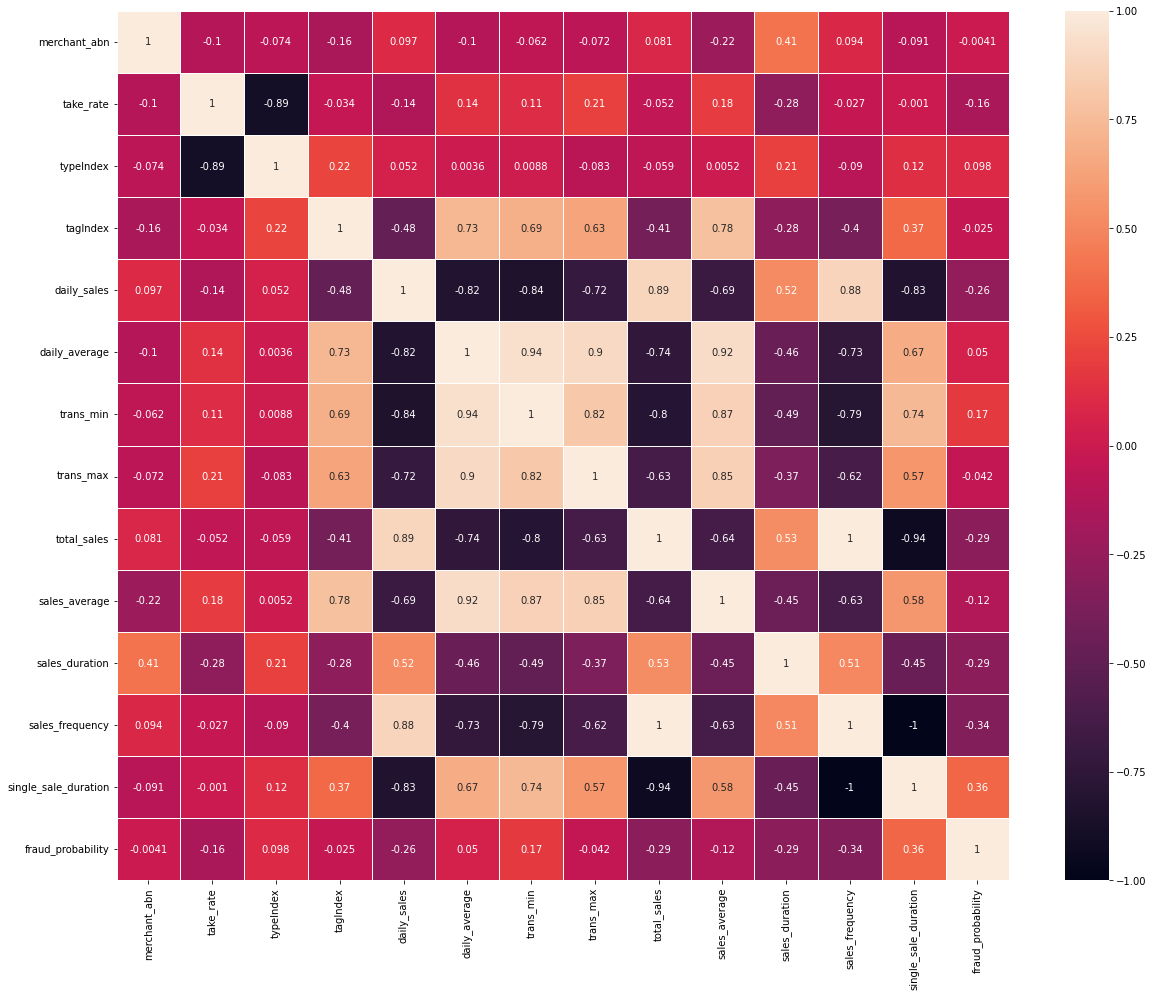

In [126]:
fig = plt.figure(figsize=(20,16))
sns.heatmap(corr,annot = True, linewidths=1)
plt.show()

- Model

In [127]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [128]:
input_col = ['take_rate',  'tag_vec', 'daily_sales', 'daily_average', 'trans_min', 'trans_max','total_sales','sales_average','sales_duration']

In [129]:
vecAssembler = VectorAssembler(inputCols=input_col, outputCol="features")

In [130]:
train_dataset = vecAssembler.transform(train_fraud_table)

In [131]:
train_dataset.show(5)

+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+------------------+----------+-----------+---------+--------------------+
|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|daily_sales|     daily_average|         trans_min|         trans_max|total_sales|     sales_average|sales_duration|   sales_frequency|single_sale_duration| fraud_probability|order_year|order_month|order_day|            features|
+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+------------------+----------+-----------+---------+--------------------+
| 35909341340|      4.8|      1.0|     8.0| (24,[8],[1.0])|     2040.0| 286.2517545284905|14.358097448846088| 2579.411256840139|   13072

In [132]:
train_dataset = train_dataset.dropna(how='any')

In [135]:
train_dataset = train_dataset.withColumnRenamed('fraud_probability', 'label')

In [137]:
train_dataset.show(5)

+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+------------------+----------+-----------+---------+--------------------+
|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|daily_sales|     daily_average|         trans_min|         trans_max|total_sales|     sales_average|sales_duration|   sales_frequency|single_sale_duration|             label|order_year|order_month|order_day|            features|
+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+------------------+----------+-----------+---------+--------------------+
| 35909341340|      4.8|      1.0|     8.0| (24,[8],[1.0])|     2040.0| 286.2517545284905|14.358097448846088| 2579.411256840139|   13072

In [139]:
lr = LinearRegression(featuresCol='features',labelCol='label', maxIter=5, regParam=0.0, solver="normal")
lr_model=lr.fit(train_dataset)

22/10/08 20:47:31 WARN Instrumentation: [31b77a1a] regParam is zero, which might cause numerical instability and overfitting.


22/10/08 20:47:32 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/10/08 20:47:32 WARN Instrumentation: [31b77a1a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [140]:
print("Correlation coefficient:{}".format(lr_model.coefficients))
print("Intercept:{}".format(lr_model.intercept))

Correlation coefficient:[-0.985157261496402,0.9721734972026502,30.142440361328774,0.0,18.63582934602787,40.30279697430407,20.93433898241675,17.858431718779045,16.165619372845274,5.940394437666231,9.326067801329446,9.451521538911647,9.081923025088244,21.546769213173324,0.2988221640975538,0.0,2.5119381841907367,4.7623861374087335,0.0,4.501505750182669,-3.6741004556857146,-3.659885171408254,0.0,-5.4563551643303345,-2.029939418258278,-0.004170174253914978,0.00044043420703664794,0.0008248149683324527,-4.502890322884374e-05,-6.128395055877601e-05,-0.0024696128150402965,-0.03954776353345296]
Intercept:53.310165087369676


In [141]:
training_predictions=lr_model.evaluate(train_dataset) 

In [142]:
print('{}{}'.format('Mean Square Error:',training_predictions.meanSquaredError))
print('{}{}'.format('R2 determination factor：',training_predictions.r2 ))

Mean Square Error:76.28821182203646
R2 determination factor：0.7145353136959819


In [143]:
test_feature = vecAssembler.transform(test_fraud_table)

In [144]:
test_feature.show(5)

+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+----------+-----------+---------+--------------------+
|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|daily_sales|     daily_average|         trans_min|         trans_max|total_sales|     sales_average|sales_duration|   sales_frequency|single_sale_duration|order_year|order_month|order_day|            features|
+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+----------+-----------+---------+--------------------+
| 80166805919|     1.56|      2.0|    12.0|(24,[12],[1.0])|         32|156.16499955185907|23.979396106415884|  623.094259904411|      20544|156.79778610887874|           183|112.26229508196721|

In [145]:
test_pred = lr_model.transform(test_feature)

In [146]:
test_pred.show(5)

+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+----------+-----------+---------+--------------------+-----------------+
|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|daily_sales|     daily_average|         trans_min|         trans_max|total_sales|     sales_average|sales_duration|   sales_frequency|single_sale_duration|order_year|order_month|order_day|            features|       prediction|
+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+----------+-----------+---------+--------------------+-----------------+
| 80166805919|     1.56|      2.0|    12.0|(24,[12],[1.0])|         32|156.16499955185907|23.979396106415884|  623.094259904411|      20544

In [147]:
test_pred = test_pred.withColumnRenamed('prediction', 'fraud_probability')

In [148]:
test_pred.show(5)

+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+----------+-----------+---------+--------------------+-----------------+
|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|daily_sales|     daily_average|         trans_min|         trans_max|total_sales|     sales_average|sales_duration|   sales_frequency|single_sale_duration|order_year|order_month|order_day|            features|fraud_probability|
+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+----------+-----------+---------+--------------------+-----------------+
| 80166805919|     1.56|      2.0|    12.0|(24,[12],[1.0])|         32|156.16499955185907|23.979396106415884|  623.094259904411|      20544

In [154]:
test_pred.agg({'fraud_probability': 'min'}).show()

+----------------------+
|min(fraud_probability)|
+----------------------+
|     -96.9798761882872|
+----------------------+



In [155]:
test_pred.agg({'fraud_probability': 'max'}).show()

+----------------------+
|max(fraud_probability)|
+----------------------+
|     88.32508275993287|
+----------------------+



In [156]:
test_pred.agg({'fraud_probability': 'avg'}).show()

+----------------------+
|avg(fraud_probability)|
+----------------------+
|    50.413229964710695|
+----------------------+



- GLM Model

In [171]:
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=10, regParam=0.3)
glr_model=glr.fit(train_dataset)

In [172]:
# Print the coefficients and intercept for generalized linear regression model
print("Coefficients: " + str(glr_model.coefficients))
print("Intercept: " + str(glr_model.intercept))

Coefficients: [-1.025538834046884,-1.0948964448450198,31.9416068157596,0.0,14.87675131240496,53.47391401856588,17.16687797903123,21.60739213850014,13.848257176407179,6.062921379788181,6.626383180050495,6.981925249462251,6.995810947316921,17.550679487066276,0.04341989471728113,0.0,3.1007920599708054,2.769130701822751,0.0,1.3042567812363484,-4.666827322817648,-4.2362328168180055,0.0,-7.308296708769718,-0.8154274165391301,-0.0022026662263659722,0.00026072247555227,0.0007771001924171741,-2.7445486098341923e-05,-0.00013198760845711726,-0.0024362151648899127,-0.1209474433758691]
Intercept: 72.39320452413949


In [173]:
train_glr_pred = glr_model.transform(train_dataset)

In [174]:
test_glr_pred = glr_model.transform(test_feature)

In [175]:
test_glr_pred = test_glr_pred.withColumnRenamed('prediction', 'fraud_probability')

In [176]:
test_glr_pred.show(5)

+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+----------+-----------+---------+--------------------+------------------+
|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|daily_sales|     daily_average|         trans_min|         trans_max|total_sales|     sales_average|sales_duration|   sales_frequency|single_sale_duration|order_year|order_month|order_day|            features| fraud_probability|
+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+----------+-----------+---------+--------------------+------------------+
| 80166805919|     1.56|      2.0|    12.0|(24,[12],[1.0])|         32|156.16499955185907|23.979396106415884|  623.094259904411|      20

In [177]:
test_glr_pred.agg({'fraud_probability': 'min'}).show()

+----------------------+
|min(fraud_probability)|
+----------------------+
|   -154.36703186152062|
+----------------------+



In [178]:
test_glr_pred.agg({'fraud_probability': 'max'}).show()

+----------------------+
|max(fraud_probability)|
+----------------------+
|    104.94401430772233|
+----------------------+



In [179]:
test_glr_pred.agg({'fraud_probability': 'avg'}).show()

+----------------------+
|avg(fraud_probability)|
+----------------------+
|     52.97102130877427|
+----------------------+



- Decision Tree Regression Model

In [181]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator


# Using a decision tree model
dt = DecisionTreeRegressor(featuresCol="features")


model = dt.fit(train_dataset)

# Predictions
dfpredictions = model.transform(train_dataset)
dfpredictions.select("prediction", "label", "features").show(5)

# Evaluation
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(dfpredictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
|29.011288534224313| 29.13305311007307|(32,[0,9,25,26,27...|
|29.011288534224313|29.539733207182703|(32,[0,11,25,26,2...|
|29.011288534224313|28.504479048104585|(32,[0,5,25,26,27...|
|29.011288534224313|28.956947892226466|(32,[0,17,25,26,2...|
|27.514968025268885|27.514968025268885|(32,[0,20,25,26,2...|
+------------------+------------------+--------------------+
only showing top 5 rows



Root Mean Squared Error (RMSE) on test data = 2.47111


In [180]:
dfpredictions.show()

+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+------------------+----------+-----------+---------+--------------------+------------------+
|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|daily_sales|     daily_average|         trans_min|         trans_max|total_sales|     sales_average|sales_duration|   sales_frequency|single_sale_duration|             label|order_year|order_month|order_day|            features|        prediction|
+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+------------------+----------+-----------+---------+--------------------+------------------+
| 35909341340|      4.8|      1.0|     8.0| (24,[8],[1.0])|     2040.0| 286.251

In [151]:
test_dt_prediction = model.transform(test_feature)

In [152]:
test_dt_prediction = test_dt_prediction.withColumnRenamed('prediction', 'fraud_probability')

In [153]:
test_dt_prediction.show(5)

+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+----------+-----------+---------+--------------------+------------------+
|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|daily_sales|     daily_average|         trans_min|         trans_max|total_sales|     sales_average|sales_duration|   sales_frequency|single_sale_duration|order_year|order_month|order_day|            features| fraud_probability|
+------------+---------+---------+--------+---------------+-----------+------------------+------------------+------------------+-----------+------------------+--------------+------------------+--------------------+----------+-----------+---------+--------------------+------------------+
| 80166805919|     1.56|      2.0|    12.0|(24,[12],[1.0])|         32|156.16499955185907|23.979396106415884|  623.094259904411|      20

In [157]:
test_dt_prediction.agg({'fraud_probability': 'min'}).show()

+----------------------+
|min(fraud_probability)|
+----------------------+
|    24.814781727571255|
+----------------------+



In [158]:
test_dt_prediction.agg({'fraud_probability': 'max'}).show()

+----------------------+
|max(fraud_probability)|
+----------------------+
|     91.09606847149965|
+----------------------+



In [159]:
test_dt_prediction.agg({'fraud_probability': 'avg'}).show()

+----------------------+
|avg(fraud_probability)|
+----------------------+
|     43.47678616895166|
+----------------------+



In [41]:
temp_record_sdf(test_dt_prediction, '../data/curated/merchant_fraud.parquet','overwrite')

|> Waitting for saving...
|> The folder already exist! Change the attr `overwrite` to cover the origin data.
